# LDA

import libraries

In [1]:
#import
import os
import numpy as np
import pandas as pd
import re
import itertools
from collections import Counter
import pickle
import jieba
import matplotlib.pyplot as plt
import gensim
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim
from pprint import pprint

Reading the files as list of list, the smaller list containing a pair of text and filename.

In [2]:
#--reading the texts files
le_chemin = 'cleaned_articles'  # write the texts folder path

filenames = os.listdir(le_chemin)

lst = []

for filename in sorted(os.listdir(le_chemin)):  # for all file names in folder cleaned_articles
    #ignore hidden files
    if filename[0] != '.':

        file_path = os.path.join(le_chemin, filename)  # Create path with folder path and file names
        #x = file_path[17:-4]
        x = int(filename[:-4]) #we want the filename/id as int and not string
        boite = []
        with open(file_path, 'r') as f2:
            data = f2.read() #take the text in the file
       
        boite.append(x)
        boite.append(data)
        
        lst.append(boite)

Transform the list of list into a dataframe

In [3]:
df_texts = pd.DataFrame(lst) 


Let's check that everything is correct

In [4]:
df_texts.head()

,0,1
0,1,个临时发往武汉的口罩\n个临时发往武汉的口罩个临时发往武汉的口罩个临时发往武汉的口罩吴呈杰报...
1,10,武汉封城后的宠物营救计划人类犯错的后果不该由它们承担\n武汉封城后的宠物营救计划人类犯错的后...
2,100,黄冈一个武汉周边城市的疫情防控样本\n黄冈一个武汉周边城市的疫情防控样本黄冈一个武汉周边城市...
3,1000,超长相处期被父母逼疯的年轻人\n超长相处期被父母逼疯的年轻人超长相处期被父母逼疯的年轻人超长...
4,1001,武汉后临时外卖员我多跑一单就减少一个家庭感染的可能\n武汉后临时外卖员我多跑一单就减少一个家...


Now let's rename the dataframe columns. (we do not want to set the id column as index because some files are missing)

In [5]:
df_texts = df_texts.rename(columns = {0:'id',1:'texts'})
df_texts.head()

,id,texts
0,1,个临时发往武汉的口罩\n个临时发往武汉的口罩个临时发往武汉的口罩个临时发往武汉的口罩吴呈杰报...
1,10,武汉封城后的宠物营救计划人类犯错的后果不该由它们承担\n武汉封城后的宠物营救计划人类犯错的后...
2,100,黄冈一个武汉周边城市的疫情防控样本\n黄冈一个武汉周边城市的疫情防控样本黄冈一个武汉周边城市...
3,1000,超长相处期被父母逼疯的年轻人\n超长相处期被父母逼疯的年轻人超长相处期被父母逼疯的年轻人超长...
4,1001,武汉后临时外卖员我多跑一单就减少一个家庭感染的可能\n武汉后临时外卖员我多跑一单就减少一个家...


let's reorder the dataframe based on the id column

In [6]:
df_texts = df_texts.sort_values(by = 'id' )
df_texts.head()

,id,texts
0,1,个临时发往武汉的口罩\n个临时发往武汉的口罩个临时发往武汉的口罩个临时发往武汉的口罩吴呈杰报...
1108,2,武汉隔离疫区信息孤岛与一辆鄂车的漂流\n武汉隔离疫区信息孤岛与一辆鄂车的漂流武汉隔离疫区信息...
2206,3,我家离华南海鲜市场很近返乡封城过年一位武汉大学生的过去一周\n我家离华南海鲜市场很近返乡封城...
3304,4,疫情危机中不被看见的人们武汉周边城市百姓的自救行动\n疫情危机中不被看见的人们武汉周边城市百...
3860,5,孝感前线医生武汉更难我们下面不好意思提要求\n孝感前线医生武汉更难我们下面不好意思提要求孝感...


Reset the index after re-ordering

In [7]:
df_texts = df_texts.reset_index(drop=True)
df_texts.head()

,id,texts
0,1,个临时发往武汉的口罩\n个临时发往武汉的口罩个临时发往武汉的口罩个临时发往武汉的口罩吴呈杰报...
1,2,武汉隔离疫区信息孤岛与一辆鄂车的漂流\n武汉隔离疫区信息孤岛与一辆鄂车的漂流武汉隔离疫区信息...
2,3,我家离华南海鲜市场很近返乡封城过年一位武汉大学生的过去一周\n我家离华南海鲜市场很近返乡封城...
3,4,疫情危机中不被看见的人们武汉周边城市百姓的自救行动\n疫情危机中不被看见的人们武汉周边城市百...
4,5,孝感前线医生武汉更难我们下面不好意思提要求\n孝感前线医生武汉更难我们下面不好意思提要求孝感...


We have a perfect dataframe. It is easy to display and the texts are easy to access individually or in group. We can save it just in case.

In [8]:
#df_texts.to_csv (r'df_texts_without_index.csv', index = False, header=True) #save it without index if we want to open it with R
#df_texts.to_csv (r'df_texts_with_index.csv', index = False, header=True) #with index

The texts are already quite clean. We need to cut them with jieba. We start by loading our words into jieba before cutting

In [9]:
with open('UsrWords.txt', 'r', encoding='utf8') as f:
    custom_noun = f.readlines()
    for noun in custom_noun:
        jieba.add_word(noun.replace('\n', ''), freq=None, tag='n')

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.516 seconds.
Prefix dict has been built successfully.


cutting

In [10]:
df_texts['words'] = df_texts.texts.apply(jieba.lcut)
df_texts.head()

,id,texts,words
0,1,个临时发往武汉的口罩\n个临时发往武汉的口罩个临时发往武汉的口罩个临时发往武汉的口罩吴呈杰报...,"[个, 临时, 发, 往, 武汉, 的, 口罩, \n, 个, 临时, 发, 往, 武汉, ..."
1,2,武汉隔离疫区信息孤岛与一辆鄂车的漂流\n武汉隔离疫区信息孤岛与一辆鄂车的漂流武汉隔离疫区信息...,"[武汉, 隔离, 疫区, 信息, 孤岛, 与, 一辆, 鄂车, 的, 漂流, \n, 武汉,..."
2,3,我家离华南海鲜市场很近返乡封城过年一位武汉大学生的过去一周\n我家离华南海鲜市场很近返乡封城...,"[我家, 离, 华南, 海鲜, 市场, 很近, 返乡, 封城, 过年, 一位, 武汉, 大学..."
3,4,疫情危机中不被看见的人们武汉周边城市百姓的自救行动\n疫情危机中不被看见的人们武汉周边城市百...,"[疫情, 危机, 中, 不, 被, 看见, 的, 人们, 武汉, 周边城市, 百姓, 的, ..."
4,5,孝感前线医生武汉更难我们下面不好意思提要求\n孝感前线医生武汉更难我们下面不好意思提要求孝感...,"[孝感, 前线, 医生, 武汉, 更难, 我们, 下面, 不好意思, 提, 要求, \n, ..."


Stopwords removal

In [11]:
fh = open("stopwords.txt")
stopwords=[]
stopwords.append('\n') #append the '\n' in the beginning otherwise it would be erased by strip
stopwords.append('%')  #we append some special characters, I am also goign to add it to the cleaning function pre-processing
stopwords.append('|')  #the texts but sometimes it does not catch them all
stopwords.append('△')
stopwords.append('▼')
stopwords.append('｜')
stopwords.append('\u3000') #this is a special empty space, I also removed tab space in the cleaning function, perhaps that'll help too
for line in fh:
    line = line.rstrip()
    stopwords.append(line)

def stp_removal(wordlist, stopwords=stopwords):
    lili=[]
    for word in wordlist:
        if word not in stopwords:
            lili.append(word)
    return lili


In [12]:
df_texts['cleaned_words'] = df_texts.words.apply(stp_removal)
df_texts.head()

,id,texts,words,cleaned_words
0,1,个临时发往武汉的口罩\n个临时发往武汉的口罩个临时发往武汉的口罩个临时发往武汉的口罩吴呈杰报...,"[个, 临时, 发, 往, 武汉, 的, 口罩, \n, 个, 临时, 发, 往, 武汉, ...","[临时, 发, 武汉, 口罩, 临时, 发, 武汉, 口罩, 临时, 发, 武汉, 口罩, ..."
1,2,武汉隔离疫区信息孤岛与一辆鄂车的漂流\n武汉隔离疫区信息孤岛与一辆鄂车的漂流武汉隔离疫区信息...,"[武汉, 隔离, 疫区, 信息, 孤岛, 与, 一辆, 鄂车, 的, 漂流, \n, 武汉,...","[武汉, 隔离, 疫区, 信息, 孤岛, 一辆, 鄂车, 漂流, 武汉, 隔离, 疫区, 信..."
2,3,我家离华南海鲜市场很近返乡封城过年一位武汉大学生的过去一周\n我家离华南海鲜市场很近返乡封城...,"[我家, 离, 华南, 海鲜, 市场, 很近, 返乡, 封城, 过年, 一位, 武汉, 大学...","[我家, 华南, 海鲜, 市场, 很近, 返乡, 封城, 过年, 一位, 武汉, 大学生, ..."
3,4,疫情危机中不被看见的人们武汉周边城市百姓的自救行动\n疫情危机中不被看见的人们武汉周边城市百...,"[疫情, 危机, 中, 不, 被, 看见, 的, 人们, 武汉, 周边城市, 百姓, 的, ...","[疫情, 危机, 看见, 武汉, 周边城市, 百姓, 自救, 行动, 疫情, 危机, 看见,..."
4,5,孝感前线医生武汉更难我们下面不好意思提要求\n孝感前线医生武汉更难我们下面不好意思提要求孝感...,"[孝感, 前线, 医生, 武汉, 更难, 我们, 下面, 不好意思, 提, 要求, \n, ...","[孝感, 前线, 医生, 武汉, 更难, 下面, 不好意思, 提, 要求, 孝感, 前线, ..."


check if necessary

In [13]:
x = df_texts.cleaned_words[df_texts.id == 5]
print(x)
print(list(x))

4    [孝感, 前线, 医生, 武汉, 更难, 下面, 不好意思, 提, 要求, 孝感, 前线, ...
Name: cleaned_words, dtype: object
[['孝感', '前线', '医生', '武汉', '更难', '下面', '不好意思', '提', '要求', '孝感', '前线', '医生', '武汉', '更难', '下面', '不好意思', '提', '要求', '孝感', '前线', '医生', '武汉', '更难', '下面', '不好意思', '提', '要求', '孝感', '前线', '医生', '武汉', '更难', '下面', '不好意思', '提', '要求', '卫诗婕', '记录', '浮沉', '时代', '价值', '变迁', '全面', '真实', '深入', '准确', '虚构', '每周', '送', '武安', '医生', '化名', '医院', '孝感市', '三家', '抗疫', '医院', '距离', '武汉', '公里', '孝感', '距离', '武汉', '最近', '地级市', '截止', '上午', '确诊', '病例', '例', '暴风', '眼', '武汉', '孝感', '代表', '武汉', '周边', '小城', '正在', '经历', '决战', '时刻', '坐诊', '之外', '武安', '参与', '数十个', '民间', '互助', '组织', '捐赠', '物资', '接到', '省内', '百家', '医院', '目睹', '抗疫', '前线', '真实', '画面', '本文', '电话', '采访', '晚', '进行', '继续', '关注', '疫区', '最新', '疫情', '进展', '全省', '医院', '当成', '兄弟', '医院', '一点', '没留', '对外', '发布', '求助', '信息', '知名', '基金组织', '联系', '几乎', '联系', '湖北', '二甲', '医院', '一线', '医生', '深入', '参与', '民间', '物资', '对接', '后来', '一下子', '衍生', '几十个', '互助', '群', '现在', '每天', '睁眼', '物资', '信息', '民间团体',

Prepare to LDA (we try to keep the naming consistant this time)

In [14]:
data_lemmatized = df_texts.cleaned_words
#print(data_lemmatized)

id2word = gensim.corpora.Dictionary(data_lemmatized)

id2word.filter_extremes(no_above= 0.17)    #no_above is filtering the most common words, we will try 0.17 first
                                           #and 0.28 later

corpus = [id2word.doc2bow(doc) for doc in data_lemmatized]




Because we already did some exploratory work in the other lda doc. This time we are directly looking for what number of subject is best. We also directly increase the number of iterations for more stable results, and the number of workers (thread used by the computer) to speed up the result.

In [15]:
import os
from gensim.models.wrappers import LdaMallet
os.environ.update({'MALLET_HOME':r'/home/bilatli/DEV/mallet-2.0.8/'}) 
#You should update this path as per the path of Mallet directory on your system.
mallet_path = r'/home/bilatli/DEV/mallet-2.0.8/bin/mallet' 
#You should update this path as per the path of Mallet directory on your system.

def coherence_values_computation(dictionary, corpus, texts, limit, start=2, step=3):
   coherence_values = []
   model_list = []
   for num_topics in range(start, limit, step):
      model = gensim.models.wrappers.LdaMallet(
         mallet_path, corpus=corpus, num_topics=num_topics, iterations=1000, workers = 6, id2word=id2word
      )
      model_list.append(model)
      
      coherencemodel = CoherenceModel(
      model=model, texts=texts, dictionary=dictionary, coherence='c_v'
   )
      coherence_values.append(coherencemodel.get_coherence())
   return model_list, coherence_values

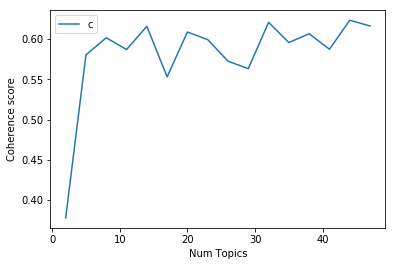

In [45]:
model_list, coherence_values = coherence_values_computation (
   dictionary=id2word, corpus=corpus, texts=data_lemmatized, 
   start=2, limit=50, step=3
)

limit=50; start=2; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [46]:
for m, cv in zip(x, coherence_values):
   print("Num Topics =", m, " is having Coherence Value of", round(cv, 4))

Num Topics = 2  is having Coherence Value of 0.3778
Num Topics = 5  is having Coherence Value of 0.5803
Num Topics = 8  is having Coherence Value of 0.6016
Num Topics = 11  is having Coherence Value of 0.5869
Num Topics = 14  is having Coherence Value of 0.6158
Num Topics = 17  is having Coherence Value of 0.553
Num Topics = 20  is having Coherence Value of 0.6086
Num Topics = 23  is having Coherence Value of 0.5992
Num Topics = 26  is having Coherence Value of 0.5724
Num Topics = 29  is having Coherence Value of 0.5631
Num Topics = 32  is having Coherence Value of 0.6207
Num Topics = 35  is having Coherence Value of 0.5956
Num Topics = 38  is having Coherence Value of 0.6065
Num Topics = 41  is having Coherence Value of 0.5873
Num Topics = 44  is having Coherence Value of 0.6233
Num Topics = 47  is having Coherence Value of 0.6162


let's check some of them

In [48]:
optimal_model = model_list[2]

model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, id2word)
vis


#model_topics = optimal_model.show_topics(formatted=False)
#pprint(optimal_model.print_topics(num_words=10))

/home/bilatli/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:236: RuntimeWarning: divide by zero encountered in log
  log_1 = np.log(pd.eval("(topic_given_term.T / topic_proportion)"))
/home/bilatli/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:259: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(pd.eval("topic_term_dists / term_proportion")).astype("float64")
/home/bilatli/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:260: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists).astype("float64")


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.276069 -0.105596       1        1  22.086951
1      0.223545 -0.143016       2        1  12.666131
0     -0.107052  0.143207       3        1  12.121393
6     -0.121021 -0.033275       4        1  11.264397
4     -0.208046 -0.204994       5        1  10.765815
3     -0.055019  0.123250       6        1  10.608969
5      0.162524  0.222627       7        1  10.547697
2     -0.171001 -0.002203       8        1   9.938648, topic_info=       Term         Freq        Total Category  logprob  loglift
22908   意大利  5823.000000  5823.000000  Default  30.0000  30.0000
11670    登录  3697.000000  3697.000000  Default  29.0000  29.0000
10310    韩国  3661.000000  3661.000000  Default  28.0000  28.0000
14948    方舱  3920.000000  3920.000000  Default  27.0000  27.0000
4213     疫苗  2669.000000  2669.000000  Default  26.0000  26.0000
22669    伊朗  2974.000000  2974.000000  Default  25.0000  25.0000
2990     英国  2468.000000  2468.000000  Default  24.0000  24.0000
130      医用  2243.000000  2243.000000  Default  23.0000  23.0000
22684    博客  2016.000000  2016.000000  Default  22.0000  22.0000
2991     药物  2347.000000  2347.000000  Default  21.0000  21.0000
695      司机  1955.000000  1955.000000  Default  20.0000  20.0000
1122     航班  1901.000000  1901.000000  Default  19.0000  19.0000
2842     德国  1872.000000  1872.000000  Default  18.0000  18.0000
17110    金融  2219.000000  2219.000000  Default  17.0000  17.0000
497      采购  1834.000000  1834.000000  Default  16.0000  16.0000
5916     投资  2455.000000  2455.000000  Default  15.0000  15.0000
2619   疾控中心  2606.000000  2606.000000  Default  14.0000  14.0000
3097     乘客  1858.000000  1858.000000  Default  13.0000  13.0000
823      心理  2079.000000  2079.000000  Default  12.0000  12.0000
2759    医疗队  2415.000000  2415.000000  Default  11.0000  11.0000
10709   李文亮  2470.000000  2470.000000  Default  10.0000  10.0000
22726    政经  1844.000000  1844.000000  Default   9.0000   9.0000
3014      课  1994.000000  1994.000000  Default   8.0000   8.0000
836     感染者  2437.000000  2437.000000  Default   7.0000   7.0000
385      物流  1675.000000  1675.000000  Default   6.0000   6.0000
2183     病区  1534.000000  1534.000000  Default   5.0000   5.0000
19772  个人观点  1416.000000  1416.000000  Default   4.0000   4.0000
1719   公共卫生  1996.000000  1996.000000  Default   3.0000   3.0000
723      回国  1473.000000  1473.000000  Default   2.0000   2.0000
8425     入境  1744.000000  1744.000000  Default   1.0000   1.0000
...     ...          ...          ...      ...      ...      ...
18449  日本政府   280.113011   280.113011   Topic8  -6.9683   2.3087
25629    数说   280.113011   280.113011   Topic8  -6.9683   2.3087
27728    瑞士   275.110993   275.110993   Topic8  -6.9863   2.3087
16476    欧元   269.108571   269.108571   Topic8  -7.0084   2.3087
2990     英国  2388.963821  2468.218973   Topic8  -4.8249   2.2761
18542    法国  1083.437110  1115.345028   Topic8  -5.6156   2.2797
10310    韩国  3391.368238  3661.041614   Topic8  -4.4745   2.2322
723      回国  1389.560614  1473.962205   Topic8  -5.3668   2.2498
4805     比赛   485.195751   493.945185   Topic8  -6.4190   2.2909
33863   新天地   587.236919   603.705522   Topic8  -6.2281   2.2811
3097     乘客  1726.696631  1858.727170   Topic8  -5.1496   2.2351
22907    总统   692.279298   720.070066   Topic8  -6.0635   2.2694
9150     包机   517.208666   535.735845   Topic8  -6.3551   2.2735
4628     公民   621.250642   661.255151   Topic8  -6.1718   2.2463
22669    伊朗  2436.983194  2974.271371   Topic8  -4.8050   2.1095
23694   特朗普  1142.460923  1294.795502   Topic8  -5.5626   2.1836
4834    留学生   932.376164  1034.257686   Topic8  -5.7658   2.2050
4776    新加坡   741.299075   804.639479   Topic8  -5.9951   2.2267
8554     旅行   843.340243   944.743605   Topic8  -5.8662   2.1952
943      机场  1528.616716  1942.947521   Topic8  -5.2714   2.0689
8425     入境  1331.537205  1744.281571

In [49]:
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.004*"产品" + 0.004*"昼" + 0.004*"游戏" + 0.004*"线上" + 0.004*"业务" + 0.004*"直播" '
  '+ 0.003*"在线" + 0.003*"办公" + 0.003*"收入" + 0.003*"学生"'),
 (1,
  '0.008*"方舱" + 0.005*"医疗队" + 0.005*"心理" + 0.004*"病区" + 0.004*"科室" + '
  '0.004*"李文亮" + 0.004*"信号" + 0.004*"中心医院" + 0.003*"父亲" + 0.003*"金银"'),
 (2,
  '0.020*"意大利" + 0.011*"韩国" + 0.008*"伊朗" + 0.008*"英国" + 0.006*"航班" + '
  '0.006*"德国" + 0.006*"乘客" + 0.005*"机场" + 0.005*"回国" + 0.005*"香港"'),
 (3,
  '0.004*"排查" + 0.004*"指挥部" + 0.004*"黄冈" + 0.004*"监狱" + 0.003*"火神" + '
  '0.003*"密切接触" + 0.003*"建设" + 0.003*"山" + 0.003*"书记" + 0.003*"中央"'),
 (4,
  '0.011*"登录" + 0.006*"博客" + 0.006*"金融" + 0.005*"政经" + 0.005*"投资" + 0.005*"课" '
  '+ 0.004*"个人观点" + 0.004*"账号" + 0.004*"私房" + 0.004*"戳"'),
 (5,
  '0.007*"医用" + 0.006*"司机" + 0.006*"采购" + 0.005*"物流" + 0.004*"快递" + 0.004*"元" '
  '+ 0.004*"价格" + 0.004*"外卖" + 0.003*"蔬菜" + 0.003*"红十字会"'),
 (6,
  '0.008*"疫苗" + 0.006*"药物" + 0.006*"疾控中心" + 0.005*"感染者" + 0.005*"公共卫生" + '
  '0.005*"诊断" + 0.004*"教授" + 0.004*"华南" + 0.004*"

In [50]:
vis = pyLDAvis.prepared_data_to_html(vis)

with open("3LDA_output.html", "w") as file:
    file.write(vis)


In [51]:
optimal_model = model_list[4]

model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, id2word)

vis

vis = pyLDAvis.prepared_data_to_html(vis)

with open("4LDA_output14s.html", "w") as file:
    file.write(vis)

/home/bilatli/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:236: RuntimeWarning: divide by zero encountered in log
  log_1 = np.log(pd.eval("(topic_given_term.T / topic_proportion)"))
/home/bilatli/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:259: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(pd.eval("topic_term_dists / term_proportion")).astype("float64")
/home/bilatli/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:260: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists).astype("float64")


In [52]:
optimal_model = model_list[14]

model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, id2word)

vis

vis = pyLDAvis.prepared_data_to_html(vis)

with open("5LDA_output44s.html", "w") as file:
    file.write(vis)

/home/bilatli/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:236: RuntimeWarning: divide by zero encountered in log
  log_1 = np.log(pd.eval("(topic_given_term.T / topic_proportion)"))
/home/bilatli/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:259: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(pd.eval("topic_term_dists / term_proportion")).astype("float64")
/home/bilatli/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:260: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists).astype("float64")


In [56]:
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

'''with open("5LDAwordlist44s.txt", "w") as file:
    file.write(str(optimal_model.print_topics(num_words=10)))'''

[(3,
  '0.027*"杂志" + 0.018*"图" + 0.016*"下降" + 0.011*"独家" + 0.009*"获取" + 0.008*"独立" '
  '+ 0.008*"责编" + 0.007*"管理者" + 0.007*"理念" + 0.007*"研究者"'),
 (30,
  '0.044*"游戏" + 0.039*"昼" + 0.026*"举报" + 0.013*"健身" + 0.009*"广告" + 0.007*"赞" + '
  '0.007*"君" + 0.007*"玩家" + 0.007*"登录" + 0.006*"敏感"'),
 (28,
  '0.015*"办公" + 0.014*"用户" + 0.012*"线上" + 0.012*"产品" + 0.012*"互联网" + '
  '0.011*"线下" + 0.011*"在线" + 0.008*"远程" + 0.008*"直播" + 0.007*"线"'),
 (12,
  '0.036*"邮轮" + 0.035*"乘客" + 0.025*"公主" + 0.020*"钻石" + 0.020*"奥运会" + '
  '0.019*"东京" + 0.015*"船上" + 0.011*"鄢成" + 0.008*"船员" + 0.008*"日本政府"'),
 (9,
  '0.015*"博客" + 0.011*"登录" + 0.010*"方方" + 0.009*"新网友" + 0.008*"常识" + 0.007*"财" '
  '+ 0.006*"个人观点" + 0.005*"老师" + 0.005*"传播者" + 0.005*"共同"'),
 (36,
  '0.038*"心理" + 0.014*"猫" + 0.013*"焦虑" + 0.010*"女性" + 0.009*"精神" + 0.008*"求助" '
  '+ 0.007*"援助" + 0.007*"干预" + 0.007*"热线" + 0.006*"宠物"'),
 (25,
  '0.023*"妈妈" + 0.015*"爸爸" + 0.014*"女儿" + 0.013*"妻子" + 0.012*"儿子" + 0.010*"丈夫" '
  '+ 0.010*"奶奶" + 0.009*"照顾" + 0.007*"哭" +

'with open("5LDAwordlist44s.txt", "w") as file:\n    file.write(str(optimal_model.print_topics(num_words=10)))'

After having written a few model, let's continue with a stronger filter

In [70]:
data_lemmatized = df_texts.cleaned_words
#print(data_lemmatized)

id2word = gensim.corpora.Dictionary(data_lemmatized)

id2word.filter_extremes(no_above= 0.28)    #no_above is filtering the most common words, let's try 0.28 now

corpus = [id2word.doc2bow(doc) for doc in data_lemmatized]

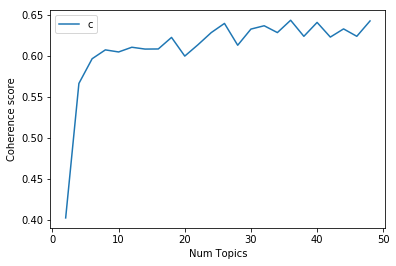

In [71]:
model_list, coherence_values = coherence_values_computation (
   dictionary=id2word, corpus=corpus, texts=data_lemmatized, 
   start=2, limit=50, step=2
)

limit=50; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [72]:
for m, cv in zip(x, coherence_values):
   print("Num Topics =", m, " is having Coherence Value of", round(cv, 4))

Num Topics = 2  is having Coherence Value of 0.4022
Num Topics = 4  is having Coherence Value of 0.5665
Num Topics = 6  is having Coherence Value of 0.5967
Num Topics = 8  is having Coherence Value of 0.6075
Num Topics = 10  is having Coherence Value of 0.6049
Num Topics = 12  is having Coherence Value of 0.6107
Num Topics = 14  is having Coherence Value of 0.6085
Num Topics = 16  is having Coherence Value of 0.6086
Num Topics = 18  is having Coherence Value of 0.6227
Num Topics = 20  is having Coherence Value of 0.5999
Num Topics = 22  is having Coherence Value of 0.6138
Num Topics = 24  is having Coherence Value of 0.6286
Num Topics = 26  is having Coherence Value of 0.6398
Num Topics = 28  is having Coherence Value of 0.6131
Num Topics = 30  is having Coherence Value of 0.6329
Num Topics = 32  is having Coherence Value of 0.6369
Num Topics = 34  is having Coherence Value of 0.6286
Num Topics = 36  is having Coherence Value of 0.6437
Num Topics = 38  is having Coherence Value of 0.62

In [73]:
optimal_model = model_list[3]

model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, id2word)

vis

vis = pyLDAvis.prepared_data_to_html(vis)

with open("6LDA_output8s-028.html", "w") as file:
    file.write(vis)

/home/bilatli/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:236: RuntimeWarning: divide by zero encountered in log
  log_1 = np.log(pd.eval("(topic_given_term.T / topic_proportion)"))
/home/bilatli/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:259: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(pd.eval("topic_term_dists / term_proportion")).astype("float64")
/home/bilatli/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:260: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists).astype("float64")


In [74]:
optimal_model = model_list[12]

model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, id2word)

vis

vis = pyLDAvis.prepared_data_to_html(vis)

with open("7LDA_output26s-028.html", "w") as file:
    file.write(vis)

/home/bilatli/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:236: RuntimeWarning: divide by zero encountered in log
  log_1 = np.log(pd.eval("(topic_given_term.T / topic_proportion)"))
/home/bilatli/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:259: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(pd.eval("topic_term_dists / term_proportion")).astype("float64")
/home/bilatli/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:260: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists).astype("float64")


In [75]:
optimal_model = model_list[17]

model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, id2word)

vis

vis = pyLDAvis.prepared_data_to_html(vis)

with open("8LDA_output36s-028.html", "w") as file:
    file.write(vis)

/home/bilatli/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:236: RuntimeWarning: divide by zero encountered in log
  log_1 = np.log(pd.eval("(topic_given_term.T / topic_proportion)"))
/home/bilatli/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:259: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(pd.eval("topic_term_dists / term_proportion")).astype("float64")
/home/bilatli/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:260: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists).astype("float64")


Let's check if gensim is comparable

In [83]:
def coherence_values_computation(dictionary, corpus, texts, limit, start=2, step=3):
   coherence_values = []
   model_list = []
   for num_topics in range(start, limit, step):
      model = gensim.models.LdaMulticore(
    corpus=corpus, num_topics=num_topics, iterations=1000, id2word=id2word
      )
      model_list.append(model)
      
      coherencemodel = CoherenceModel(
      model=model, texts=texts, dictionary=dictionary, coherence='c_v'
   )
      coherence_values.append(coherencemodel.get_coherence())
   return model_list, coherence_values

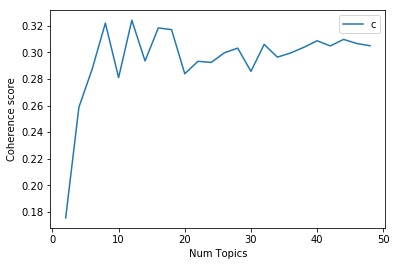

In [84]:
model_list, coherence_values = coherence_values_computation (
   dictionary=id2word, corpus=corpus, texts=data_lemmatized, 
   start=2, limit=50, step=2
)

limit=50; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [85]:
for m, cv in zip(x, coherence_values):
   print("Num Topics =", m, " is having Coherence Value of", round(cv, 4))

Num Topics = 2  is having Coherence Value of 0.1753
Num Topics = 4  is having Coherence Value of 0.2587
Num Topics = 6  is having Coherence Value of 0.2873
Num Topics = 8  is having Coherence Value of 0.3221
Num Topics = 10  is having Coherence Value of 0.281
Num Topics = 12  is having Coherence Value of 0.3242
Num Topics = 14  is having Coherence Value of 0.2936
Num Topics = 16  is having Coherence Value of 0.3184
Num Topics = 18  is having Coherence Value of 0.3171
Num Topics = 20  is having Coherence Value of 0.2839
Num Topics = 22  is having Coherence Value of 0.2933
Num Topics = 24  is having Coherence Value of 0.2925
Num Topics = 26  is having Coherence Value of 0.2998
Num Topics = 28  is having Coherence Value of 0.3032
Num Topics = 30  is having Coherence Value of 0.2857
Num Topics = 32  is having Coherence Value of 0.306
Num Topics = 34  is having Coherence Value of 0.2964
Num Topics = 36  is having Coherence Value of 0.2996
Num Topics = 38  is having Coherence Value of 0.3039

The stabilisation appears around the same number, around 8/12 subjects, but the coherence value is much lower. Let's see what it looks like

In [87]:
optimal_model = model_list[3]

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)

vis = pyLDAvis.prepared_data_to_html(vis)

with open("9LDA_output8s-028gensim.html", "w") as file:
    file.write(vis)

Somehow the results are much less good than what we extracted with mallet. Let's try to stick with mallet.

In [94]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=8, iterations=1000, workers = 6, id2word=id2word)

convert mallet model to gensim model

In [107]:
from gensim.models.ldamodel import LdaModel

def convertldaMalletToldaGen(mallet_model):
    model_gensim = LdaModel(
        id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,
        alpha=mallet_model.alpha) 
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim

In [108]:
ldagensim = convertldaMalletToldaGen(ldamallet)

Let's see if we can add dominant topic per document. After that we will be able to choose what documents to translate based on that, at least partially.

In [117]:
def format_topics_sentences(ldamodel=ldagensim, corpus=corpus, texts=df_texts.texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=ldagensim, corpus=corpus, texts=df_texts.texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,5.0,0.3339,"复工, 生产, 员工, 行业, 需求, 产品, 工厂, 昼, 销售, 价格",个临时发往武汉的口罩\n个临时发往武汉的口罩个临时发往武汉的口罩个临时发往武汉的口罩吴呈杰报...
1,1,2.0,0.8115,"孩子, 出门, 回来, 小区, 妈妈, 母亲, 超市, 群里, 东西, 开",武汉隔离疫区信息孤岛与一辆鄂车的漂流\n武汉隔离疫区信息孤岛与一辆鄂车的漂流武汉隔离疫区信息...
2,2,2.0,0.6531,"孩子, 出门, 回来, 小区, 妈妈, 母亲, 超市, 群里, 东西, 开",我家离华南海鲜市场很近返乡封城过年一位武汉大学生的过去一周\n我家离华南海鲜市场很近返乡封城...
3,3,2.0,0.3969,"孩子, 出门, 回来, 小区, 妈妈, 母亲, 超市, 群里, 东西, 开",疫情危机中不被看见的人们武汉周边城市百姓的自救行动\n疫情危机中不被看见的人们武汉周边城市百...
4,4,2.0,0.3782,"孩子, 出门, 回来, 小区, 妈妈, 母亲, 超市, 群里, 东西, 开",孝感前线医生武汉更难我们下面不好意思提要求\n孝感前线医生武汉更难我们下面不好意思提要求孝感...
5,5,0.0,0.4307,"护士, 方舱, 病房, 床位, 门诊, 收治, 出院, 医疗队, 家属, 核酸",恐慌很正常当疫情结束才是心理问题高发期\n恐慌很正常当疫情结束才是心理问题高发期恐慌很正常当...
6,6,2.0,0.4933,"孩子, 出门, 回来, 小区, 妈妈, 母亲, 超市, 群里, 东西, 开",外卖骑手出租车司机快递员志愿者封城九日他们维护着武汉的血脉\n外卖骑手出租车司机快递员志愿者...
7,7,1.0,0.4062,"回复, 日记, 老师, 学生, 游戏, 写, 学校, 学习, 微博, 网络",疫情中的心理援助寻找局部的安全\n疫情中的心理援助寻找局部的安全疫情中的心理援助寻找局部的安...
8,8,2.0,0.6047,"孩子, 出门, 回来, 小区, 妈妈, 母亲, 超市, 群里, 东西, 开",鸡在瘟疫蔓延时\n鸡在瘟疫蔓延时鸡在瘟疫蔓延时鸡在瘟疫蔓延时蔚琳颖迪呈杰敏洁报道报道记录人物...
9,9,2.0,0.8008,"孩子, 出门, 回来, 小区, 妈妈, 母亲, 超市, 群里, 东西, 开",武汉封城后的宠物营救计划人类犯错的后果不该由它们承担\n武汉封城后的宠物营救计划人类犯错的后...


we can add our id column for easy check and selection

In [123]:
contents = pd.Series(df_texts.id)
newdf = pd.concat([df_dominant_topic, contents], axis=1)
newdf

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,id
0,0,5.0,0.3339,"复工, 生产, 员工, 行业, 需求, 产品, 工厂, 昼, 销售, 价格",个临时发往武汉的口罩\n个临时发往武汉的口罩个临时发往武汉的口罩个临时发往武汉的口罩吴呈杰报...,1
1,1,2.0,0.8115,"孩子, 出门, 回来, 小区, 妈妈, 母亲, 超市, 群里, 东西, 开",武汉隔离疫区信息孤岛与一辆鄂车的漂流\n武汉隔离疫区信息孤岛与一辆鄂车的漂流武汉隔离疫区信息...,2
2,2,2.0,0.6531,"孩子, 出门, 回来, 小区, 妈妈, 母亲, 超市, 群里, 东西, 开",我家离华南海鲜市场很近返乡封城过年一位武汉大学生的过去一周\n我家离华南海鲜市场很近返乡封城...,3
3,3,2.0,0.3969,"孩子, 出门, 回来, 小区, 妈妈, 母亲, 超市, 群里, 东西, 开",疫情危机中不被看见的人们武汉周边城市百姓的自救行动\n疫情危机中不被看见的人们武汉周边城市百...,4
4,4,2.0,0.3782,"孩子, 出门, 回来, 小区, 妈妈, 母亲, 超市, 群里, 东西, 开",孝感前线医生武汉更难我们下面不好意思提要求\n孝感前线医生武汉更难我们下面不好意思提要求孝感...,5
5,5,0.0,0.4307,"护士, 方舱, 病房, 床位, 门诊, 收治, 出院, 医疗队, 家属, 核酸",恐慌很正常当疫情结束才是心理问题高发期\n恐慌很正常当疫情结束才是心理问题高发期恐慌很正常当...,6
6,6,2.0,0.4933,"孩子, 出门, 回来, 小区, 妈妈, 母亲, 超市, 群里, 东西, 开",外卖骑手出租车司机快递员志愿者封城九日他们维护着武汉的血脉\n外卖骑手出租车司机快递员志愿者...,7
7,7,1.0,0.4062,"回复, 日记, 老师, 学生, 游戏, 写, 学校, 学习, 微博, 网络",疫情中的心理援助寻找局部的安全\n疫情中的心理援助寻找局部的安全疫情中的心理援助寻找局部的安...,8
8,8,2.0,0.6047,"孩子, 出门, 回来, 小区, 妈妈, 母亲, 超市, 群里, 东西, 开",鸡在瘟疫蔓延时\n鸡在瘟疫蔓延时鸡在瘟疫蔓延时鸡在瘟疫蔓延时蔚琳颖迪呈杰敏洁报道报道记录人物...,9
9,9,2.0,0.8008,"孩子, 出门, 回来, 小区, 妈妈, 母亲, 超市, 群里, 东西, 开",武汉封城后的宠物营救计划人类犯错的后果不该由它们承担\n武汉封城后的宠物营救计划人类犯错的后...,10


Let's find out which are the most representative documents for each subjects

In [124]:
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')
for i, grp in sent_topics_outdf_grpd:
   sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet,
grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], axis=0)
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)
sent_topics_sorteddf_mallet.columns = [
   'Topic_Number', "Contribution_Perc", "Keywords", "Text"
]
sent_topics_sorteddf_mallet.head()

,Topic_Number,Contribution_Perc,Keywords,Text
0,0.0,0.8098,"护士, 方舱, 病房, 床位, 门诊, 收治, 出院, 医疗队, 家属, 核酸",这支护肾小队专门对付炎症风暴\n这支护肾小队专门对付炎症风暴这支护肾小队专门对付炎症风暴这支...
1,1.0,0.8215,"回复, 日记, 老师, 学生, 游戏, 写, 学校, 学习, 微博, 网络",网络直播上课第一周老师和学生在抓狂中适应游研社\n网络直播上课第一周老师和学生在抓狂中适应游...
2,2.0,0.8776,"孩子, 出门, 回来, 小区, 妈妈, 母亲, 超市, 群里, 东西, 开",我家接的桌酒席终于取消了丨人间\n我家接的桌酒席终于取消了丨人间我家接的桌酒席终于取消了丨人...
3,3.0,0.8724,"捐赠, 湖北省, 酒店, 志愿者, 居民, 小区, 指挥部, 医用, 累计, 保障",司法部牵头的联合调查组公布女子离汉抵京事件调查结果\n司法部牵头的联合调查组公布女子离汉抵京...
4,4.0,0.9783,"美国, 意大利, 韩国, 日本, 伊朗, 英国, 欧洲, 国内, 航班, 德国",АгентствоСокурипартнерыпровелоисследованиеакти...


In [125]:
sent_topics_sorteddf_mallet

,Topic_Number,Contribution_Perc,Keywords,Text
0,0.0,0.8098,"护士, 方舱, 病房, 床位, 门诊, 收治, 出院, 医疗队, 家属, 核酸",这支护肾小队专门对付炎症风暴\n这支护肾小队专门对付炎症风暴这支护肾小队专门对付炎症风暴这支...
1,1.0,0.8215,"回复, 日记, 老师, 学生, 游戏, 写, 学校, 学习, 微博, 网络",网络直播上课第一周老师和学生在抓狂中适应游研社\n网络直播上课第一周老师和学生在抓狂中适应游...
2,2.0,0.8776,"孩子, 出门, 回来, 小区, 妈妈, 母亲, 超市, 群里, 东西, 开",我家接的桌酒席终于取消了丨人间\n我家接的桌酒席终于取消了丨人间我家接的桌酒席终于取消了丨人...
3,3.0,0.8724,"捐赠, 湖北省, 酒店, 志愿者, 居民, 小区, 指挥部, 医用, 累计, 保障",司法部牵头的联合调查组公布女子离汉抵京事件调查结果\n司法部牵头的联合调查组公布女子离汉抵京...
4,4.0,0.9783,"美国, 意大利, 韩国, 日本, 伊朗, 英国, 欧洲, 国内, 航班, 德国",АгентствоСокурипартнерыпровелоисследованиеакти...
5,5.0,0.9160,"复工, 生产, 员工, 行业, 需求, 产品, 工厂, 昼, 销售, 价格",愼愼挼昼搼й昼挼昼戼戼搼昼挼戼昼挼搼搼搼挼戼戼愼愼愼戼攼挼攼戼搼挼昼戼愼挼戼挼搼挼挼挼搼挼昼...
6,6.0,0.8855,"评论, 登录, 代表, 观点, 金融, 博客, 仅, 政经, 投资, 微博",疫情总动员各地怎么做保交通重问责迟开学政经频道财新网\n疫情总动员各地怎么做保交通重问责迟开...
7,7.0,0.8839,"临床, 传染病, 疫苗, 药物, 疾控中心, 公共卫生, 核酸, 感染者, 诊断, 卫健委",华南海鲜市场不是病毒发源地中科院团队基因追踪零号病人再进一步\n华南海鲜市场不是病毒发源地中...


And here. Oh the irony! The most representative document for subject number 4 is in... Russian. And yes, indeed, I did not clean the articles for russian. We did not keep the id for the most representative articles so let's try to find back this mysterious russian articles.

In [126]:
df2 =newdf[newdf.Dominant_Topic==4] #selecting the problematic topic

In [131]:
df2

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,id
38,38,4.0,0.3881,"美国, 意大利, 韩国, 日本, 伊朗, 英国, 欧洲, 国内, 航班, 德国",新型肺炎阴影下迅速应对的香港\n新型肺炎阴影下迅速应对的香港新型肺炎阴影下迅速应对的香港新型...,39
79,79,4.0,0.3582,"美国, 意大利, 韩国, 日本, 伊朗, 英国, 欧洲, 国内, 航班, 德国",与武汉乘客同机双方的困境\n与武汉乘客同机双方的困境与武汉乘客同机双方的困境与武汉乘客同机双...,80
94,94,4.0,0.5035,"美国, 意大利, 韩国, 日本, 伊朗, 英国, 欧洲, 国内, 航班, 德国",海外滞留的游客你们不在孤岛上\n海外滞留的游客你们不在孤岛上海外滞留的游客你们不在孤岛上海外...,95
133,133,4.0,0.3482,"美国, 意大利, 韩国, 日本, 伊朗, 英国, 欧洲, 国内, 航班, 德国",疫情下的海外华人孤立恐慌种族歧视和鼓励\n疫情下的海外华人孤立恐慌种族歧视和鼓励疫情下的海外...,134
134,134,4.0,0.3155,"美国, 意大利, 韩国, 日本, 伊朗, 英国, 欧洲, 国内, 航班, 德国",外国人眼里的疫情中国唱国歌喝蝙蝠汤和只相信政府的中国人\n外国人眼里的疫情中国唱国歌喝蝙蝠汤...,135
287,287,4.0,0.3891,"美国, 意大利, 韩国, 日本, 伊朗, 英国, 欧洲, 国内, 航班, 德国",香港特区抗疫实录削减往来内地交通争抢口罩蔬菜\n香港特区抗疫实录削减往来内地交通争抢口罩蔬菜...,293
302,302,4.0,0.6249,"美国, 意大利, 韩国, 日本, 伊朗, 英国, 欧洲, 国内, 航班, 德国",香港抗疫实录减少人流再关口岸准备新的检疫设施\n香港抗疫实录减少人流再关口岸准备新的检疫设施...,309
307,307,4.0,0.6250,"美国, 意大利, 韩国, 日本, 伊朗, 英国, 欧洲, 国内, 航班, 德国",世卫组织称新冠肺炎还不是全球流行病其他国家如何应对\n世卫组织称新冠肺炎还不是全球流行病其他...,314
308,308,4.0,0.6660,"美国, 意大利, 韩国, 日本, 伊朗, 英国, 欧洲, 国内, 航班, 德国",中国留学生面临选择承受经济损失还是改变留学计划\n中国留学生面临选择承受经济损失还是改变留学...,315
360,360,4.0,0.3719,"美国, 意大利, 韩国, 日本, 伊朗, 英国, 欧洲, 国内, 航班, 德国",危险无人察觉世界梦号豪华邮轮疫情始末\n危险无人察觉世界梦号豪华邮轮疫情始末危险无人察觉世界...,367


In [132]:
df2.sort_values('Topic_Perc_Contrib') #reorder by percentage contribution

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,id
4205,4205,4.0,0.1585,"美国, 意大利, 韩国, 日本, 伊朗, 英国, 欧洲, 国内, 航班, 德国",«»\nÚ©,4242
4217,4217,4.0,0.1585,"美国, 意大利, 韩国, 日本, 伊朗, 英国, 欧洲, 国内, 航班, 德国",«»,4254
1137,1137,4.0,0.1814,"美国, 意大利, 韩国, 日本, 伊朗, 英国, 欧洲, 国内, 航班, 德国",确诊病例数字飙升疫情仍可能朝任何方向发展以及其他条疫情新闻\n确诊病例数字飙升疫情仍可能朝任...,1151
2224,2224,4.0,0.1852,"美国, 意大利, 韩国, 日本, 伊朗, 英国, 欧洲, 国内, 航班, 德国",全球疫情处于关键时刻负责抢救危重患者的医生确诊新冠以及其他条疫情新闻\n全球疫情处于关键时刻...,2243
4212,4212,4.0,0.1862,"美国, 意大利, 韩国, 日本, 伊朗, 英国, 欧洲, 国内, 航班, 德国",«»«»×,4249
4209,4209,4.0,0.1896,"美国, 意大利, 韩国, 日本, 伊朗, 英国, 欧洲, 国内, 航班, 德国",«»«»,4246
4210,4210,4.0,0.1896,"美国, 意大利, 韩国, 日本, 伊朗, 英国, 欧洲, 国内, 航班, 德国",«»«»Ú©,4247
4219,4219,4.0,0.1896,"美国, 意大利, 韩国, 日本, 伊朗, 英国, 欧洲, 国内, 航班, 德国",«»«»,4256
4222,4222,4.0,0.1896,"美国, 意大利, 韩国, 日本, 伊朗, 英国, 欧洲, 国内, 航班, 德国",«»«»,4259
3230,3230,4.0,0.2010,"美国, 意大利, 韩国, 日本, 伊朗, 英国, 欧洲, 国内, 航班, 德国",新冠肺炎可能成为全球大流行病种语言接力医生口述文以及其他条新闻\n新冠肺炎可能成为全球大流行...,3257


And here we can see our russian article. Actually, there are a lot of problematic articles in this category. The conclusion for this notebook is that we can start over again as it probably influenced the total result to a certain extent. Check if it is possible to find the proper version of the article, or delete the article completely and take note of the process.
The positive thing is that the lda representation are still interesting and conveying meaning despite those dirty articles.

In [134]:
df3 =newdf[newdf.Dominant_Topic==5] #selecting the problematic topic
df3

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,id
0,0,5.0,0.3339,"复工, 生产, 员工, 行业, 需求, 产品, 工厂, 昼, 销售, 价格",个临时发往武汉的口罩\n个临时发往武汉的口罩个临时发往武汉的口罩个临时发往武汉的口罩吴呈杰报...,1
35,35,5.0,0.3337,"复工, 生产, 员工, 行业, 需求, 产品, 工厂, 昼, 销售, 价格",旅行社老板荣荣我在临沂过年关原创\n旅行社老板荣荣我在临沂过年关原创旅行社老板荣荣我在临沂过...,36
41,41,5.0,0.4604,"复工, 生产, 员工, 行业, 需求, 产品, 工厂, 昼, 销售, 价格",直击肺炎有人囤货涨价用现金交易线上断货线下断供\n直击肺炎有人囤货涨价用现金交易线上断货线下...,42
43,43,5.0,0.5389,"复工, 生产, 员工, 行业, 需求, 产品, 工厂, 昼, 销售, 价格",天价口罩背后原料价一天一涨不惜亏本生产\n天价口罩背后原料价一天一涨不惜亏本生产天价口罩背后...,44
53,53,5.0,0.4349,"复工, 生产, 员工, 行业, 需求, 产品, 工厂, 昼, 销售, 价格",湖北一亿只亟需饲料的蛋鸡\n湖北一亿只亟需饲料的蛋鸡湖北一亿只亟需饲料的蛋鸡湖北一亿只亟需饲...,54
62,62,5.0,0.4281,"复工, 生产, 员工, 行业, 需求, 产品, 工厂, 昼, 销售, 价格",京东武汉战事金银潭医院米处为机枪手递上子弹深网\n京东武汉战事金银潭医院米处为机枪手递上子弹...,63
65,65,5.0,0.4848,"复工, 生产, 员工, 行业, 需求, 产品, 工厂, 昼, 销售, 价格",一位教育培训创业者的抗疫计划我们准备这样扛过三个月深网\n一位教育培训创业者的抗疫计划我们准...,66
87,87,5.0,0.5737,"复工, 生产, 员工, 行业, 需求, 产品, 工厂, 昼, 销售, 价格",口罩产能全球过半为何还是一罩难求\n口罩产能全球过半为何还是一罩难求口罩产能全球过半为何还是...,88
91,91,5.0,0.4618,"复工, 生产, 员工, 行业, 需求, 产品, 工厂, 昼, 销售, 价格",猪也饿二师兄挺住\n猪也饿二师兄挺住猪也饿二师兄挺住猪也饿二师兄挺住李晓洁杨璐三联生活周刊三...,92
118,118,5.0,0.3153,"复工, 生产, 员工, 行业, 需求, 产品, 工厂, 昼, 销售, 价格",和疫情一线的医生聊的越多就越尊重他们\n和疫情一线的医生聊的越多就越尊重他们和疫情一线的医生...,119
